<a href="https://colab.research.google.com/github/rodayna-moamen/fraud_detection_project/blob/main/ml2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

### Verifying Data Shapes and SMOTE Application

Let's check the shapes of `X_train`, `X_val`, and `X_test` to confirm the splits and that SMOTE only affected the training data.

In [41]:
print(f"Original feature set shape (X): {X.shape}")
print(f"Original target set shape (y): {y.shape}\n")

print(f"Shape after initial train-test split (X_train_val): {X_train_val.shape}")
print(f"Shape after initial train-test split (X_test): {X_test.shape}")
print(f"Shape after initial train-test split (y_train_val): {y_train_val.shape}")
print(f"Shape after initial train-test split (y_test): {y_test.shape}\n")

print(f"Shape after SMOTE (X_resampled): {X_resampled.shape}")
print(f"Shape after SMOTE (y_resampled): {y_resampled.shape}\n")

print(f"Final training set shape (X_train): {X_train.shape}")
print(f"Final validation set shape (X_val): {X_val.shape}")
print(f"Final training target shape (y_train): {y_train.shape}")
print(f"Final validation target shape (y_val): {y_val.shape}")

# Confirm that X_test remains unchanged by SMOTE
print(f"\nNumber of samples in y_train_val BEFORE SMOTE: {y_train_val.shape[0]}")
print(f"Number of samples in y_resampled AFTER SMOTE: {y_resampled.shape[0]}")
print(f"Number of samples in y_test: {y_test.shape[0]}")

if X_resampled.shape[0] > X_train_val.shape[0]:
    print("\nSMOTE successfully increased the number of samples in the training data.")
else:
    print("\nSMOTE did NOT increase the number of samples in the training data. Check SMOTE configuration.")

print("The test set (X_test, y_test) was not affected by SMOTE as its shape is unchanged from the initial split.")

Original feature set shape (X): (5410, 26)
Original target set shape (y): (5410,)

Shape after initial train-test split (X_train_val): (4328, 26)
Shape after initial train-test split (X_test): (1082, 26)
Shape after initial train-test split (y_train_val): (4328,)
Shape after initial train-test split (y_test): (1082,)

Shape after SMOTE (X_resampled): (7846, 26)
Shape after SMOTE (y_resampled): (7846,)

Final training set shape (X_train): (5884, 26)
Final validation set shape (X_val): (1962, 26)
Final training target shape (y_train): (5884,)
Final validation target shape (y_val): (1962,)

Number of samples in y_train_val BEFORE SMOTE: 4328
Number of samples in y_resampled AFTER SMOTE: 7846
Number of samples in y_test: 1082

SMOTE successfully increased the number of samples in the training data.
The test set (X_test, y_test) was not affected by SMOTE as its shape is unchanged from the initial split.


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler

# Load the dataset
train_data = pd.read_csv('/content/train_processed.csv')

# Separate features and target variable
X = train_data.drop('Fraud', axis=1)  # All columns except the target
y = train_data['Fraud']  # Target variable

# Drop non-numeric columns (e.g., 'Provider' or any other categorical features)
X = X.select_dtypes(include=['number'])  # Select only numeric columns

# Handle missing values separately for numeric columns
X.fillna(X.mean(), inplace=True)  # Impute missing values with column mean for numeric columns

# Train-Test Split (Stratified to preserve class distribution) - BEFORE SMOTE
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scaling the features (important for algorithms like Logistic Regression) - FIT ONLY ON TRAIN_VAL, TRANSFORM ALL
scaler = StandardScaler()
X_train_val_scaled = scaler.fit_transform(X_train_val)
X_test_scaled = scaler.transform(X_test)

# Handling class imbalance using SMOTE - ONLY ON TRAINING DATA
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_val_scaled, y_train_val)

# Split the resampled training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_resampled, y_resampled, test_size=0.25, random_state=42, stratify=y_resampled) # 0.25 of 80% is 20% of original data


In [ ]:
print(train_data.columns)

Index(['Provider', 'TotalClaims', 'UniquePatients', 'TotalReimbursed',
       'AvgReimbursed', 'StdReimbursed', 'MaxReimbursed', 'MinReimbursed',
       'TotalDeductible', 'AvgDeductible', 'InpatientClaims',
       'OutpatientClaims', 'ClaimsPerPatient', 'AvgReimbursedPerPatient',
       'InpatientRatio', 'OutpatientRatio', 'Alzheimer_Rate',
       'Heartfailure_Rate', 'KidneyDisease_Rate', 'Cancer_Rate',
       'ObstrPulmonary_Rate', 'Depression_Rate', 'Diabetes_Rate',
       'IschemicHeart_Rate', 'Osteoporasis_Rate', 'rheumatoidarthritis_Rate',
       'stroke_Rate', 'PotentialFraud', 'Fraud'],
      dtype='object')


In [ ]:
# Logistic Regression (Baseline Model)
logreg = LogisticRegression(class_weight='balanced', random_state=42)
logreg.fit(X_train, y_train)
y_pred_logreg = logreg.predict(X_val)

# Evaluate Logistic Regression Model
print("Logistic Regression Classification Report:\n", classification_report(y_val, y_pred_logreg))
print("Logistic Regression ROC-AUC:", roc_auc_score(y_val, y_pred_logreg))
print("Logistic Regression PR-AUC:", average_precision_score(y_val, y_pred_logreg))

Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.89      0.87       981
           1       0.88      0.85      0.87       981

    accuracy                           0.87      1962
   macro avg       0.87      0.87      0.87      1962
weighted avg       0.87      0.87      0.87      1962

Logistic Regression ROC-AUC: 0.8705402650356779
Logistic Regression PR-AUC: 0.82749968514769


In [ ]:
# Decision Tree (Baseline Model)
dt = DecisionTreeClassifier(class_weight='balanced', random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_val)

# Evaluate Decision Tree Model
print("Decision Tree Classification Report:\n", classification_report(y_val, y_pred_dt))
print("Decision Tree ROC-AUC:", roc_auc_score(y_val, y_pred_dt))
print("Decision Tree PR-AUC:", average_precision_score(y_val, y_pred_dt))

# Visualizing the Confusion Matrix for both models
from sklearn.metrics import confusion_matrix
logreg_cm = confusion_matrix(y_val, y_pred_logreg)
dt_cm = confusion_matrix(y_val, y_pred_dt)

Decision Tree Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.90      0.91       981
           1       0.90      0.92      0.91       981

    accuracy                           0.91      1962
   macro avg       0.91      0.91      0.91      1962
weighted avg       0.91      0.91      0.91      1962

Decision Tree ROC-AUC: 0.9092762487257899
Decision Tree PR-AUC: 0.86879837797269


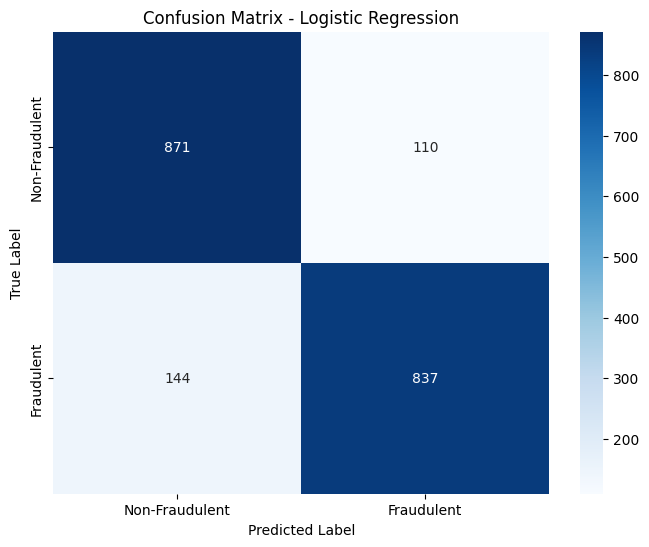

In [ ]:
# Plotting confusion matrix for Logistic Regression
plt.figure(figsize=(8, 6))
sns.heatmap(logreg_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Fraudulent', 'Fraudulent'], yticklabels=['Non-Fraudulent', 'Fraudulent'])
plt.title('Confusion Matrix - Logistic Regression')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

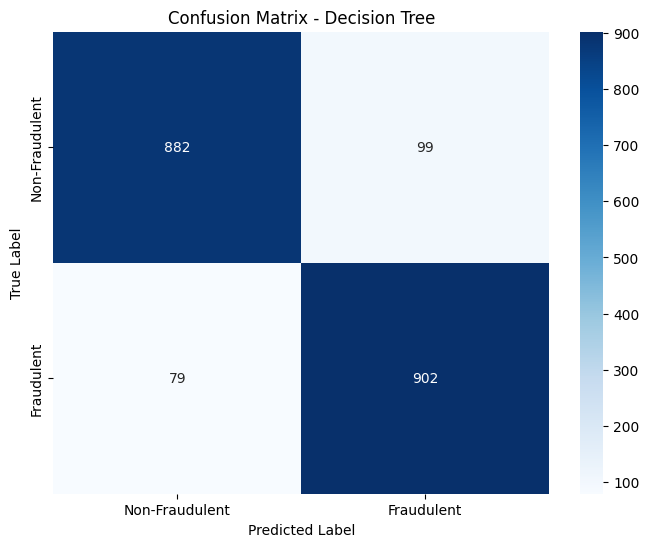

In [ ]:
# Plotting confusion matrix for Decision Tree
plt.figure(figsize=(8, 6))
sns.heatmap(dt_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Fraudulent', 'Fraudulent'], yticklabels=['Non-Fraudulent', 'Fraudulent'])
plt.title('Confusion Matrix - Decision Tree')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [ ]:
import joblib
joblib.dump(logreg, 'logreg_model.pkl')
joblib.dump(dt, 'decision_tree_model.pkl')

['decision_tree_model.pkl']

In [ ]:
# --- 1. Random Forest Model ---
rf = RandomForestClassifier(class_weight='balanced', random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_val)

# Evaluate Random Forest Model
print("Random Forest Classification Report:\n", classification_report(y_val, y_pred_rf))
print("Random Forest ROC-AUC:", roc_auc_score(y_val, y_pred_rf))
print("Random Forest PR-AUC:", average_precision_score(y_val, y_pred_rf))


Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.93      0.95       981
           1       0.94      0.96      0.95       981

    accuracy                           0.95      1962
   macro avg       0.95      0.95      0.95      1962
weighted avg       0.95      0.95      0.95      1962

Random Forest ROC-AUC: 0.946992864424057
Random Forest PR-AUC: 0.918140296213964


In [ ]:
# --- 2. Gradient Boosting Model ---
gb = GradientBoostingClassifier(random_state=42)
gb.fit(X_train, y_train)
y_pred_gb = gb.predict(X_val)

# Evaluate Gradient Boosting Model
print("Gradient Boosting Classification Report:\n", classification_report(y_val, y_pred_gb))
print("Gradient Boosting ROC-AUC:", roc_auc_score(y_val, y_pred_gb))
print("Gradient Boosting PR-AUC:", average_precision_score(y_val, y_pred_gb))

Gradient Boosting Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.89      0.91       981
           1       0.89      0.93      0.91       981

    accuracy                           0.91      1962
   macro avg       0.91      0.91      0.91      1962
weighted avg       0.91      0.91      0.91      1962

Gradient Boosting ROC-AUC: 0.9077471967380223
Gradient Boosting PR-AUC: 0.8640886069104738


In [ ]:
# --- 3. Hyperparameter Tuning for Random Forest ---
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
}

grid_search_rf = GridSearchCV(estimator=RandomForestClassifier(random_state=42), param_grid=param_grid_rf, cv=3, scoring='roc_auc')
grid_search_rf.fit(X_train, y_train)
best_rf = grid_search_rf.best_estimator_

# Best Random Forest after hyperparameter tuning
print("Best Random Forest Parameters:", grid_search_rf.best_params_)

# Evaluate tuned Random Forest
y_pred_best_rf = best_rf.predict(X_val)
print("Tuned Random Forest Classification Report:\n", classification_report(y_val, y_pred_best_rf))
print("Tuned Random Forest ROC-AUC:", roc_auc_score(y_val, y_pred_best_rf))
print("Tuned Random Forest PR-AUC:", average_precision_score(y_val, y_pred_best_rf))

Best Random Forest Parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Tuned Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.93      0.95       981
           1       0.94      0.96      0.95       981

    accuracy                           0.95      1962
   macro avg       0.95      0.95      0.95      1962
weighted avg       0.95      0.95      0.95      1962

Tuned Random Forest ROC-AUC: 0.9475025484199795
Tuned Random Forest PR-AUC: 0.9190332014032014


In [34]:
# --- 4. Hyperparameter Tuning for Gradient Boosting ---
param_grid_gb = {
    'n_estimators': [50, 100, 150],  # Reduced the range for quicker execution
    'learning_rate': [0.01, 0.1],  # Reduced the number of learning rates tested
    'max_depth': [3, 5],  # Reduced max_depth options for faster results
}

# Use GridSearchCV with parallel processing to speed up cross-validation
grid_search_gb = GridSearchCV(
    estimator=GradientBoostingClassifier(random_state=42),
    param_grid=param_grid_gb,  # Reduced parameter grid
    cv=3,  # 3-fold cross-validation instead of 5
    scoring='roc_auc',  # Optimize for ROC-AUC
    n_jobs=-1,  # Use all available CPU cores for parallel processing
    verbose=1  # Optional: Use verbose=1 to print progress
)

# Perform the grid search
grid_search_gb.fit(X_train, y_train)

# Get the best model from GridSearchCV
best_gb = grid_search_gb.best_estimator_

# Best Gradient Boosting after hyperparameter tuning
print("Best Gradient Boosting Parameters:", grid_search_gb.best_params_)

# Evaluate tuned Gradient Boosting
y_pred_best_gb = best_gb.predict(X_val)
print("Tuned Gradient Boosting Classification Report:\n", classification_report(y_val, y_pred_best_gb))
print("Tuned Gradient Boosting ROC-AUC:", roc_auc_score(y_val, y_pred_best_gb))
print("Tuned Gradient Boosting PR-AUC:", average_precision_score(y_val, y_pred_best_gb))

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best Gradient Boosting Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 150}
Tuned Gradient Boosting Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.93      0.95       981
           1       0.93      0.96      0.95       981

    accuracy                           0.95      1962
   macro avg       0.95      0.95      0.95      1962
weighted avg       0.95      0.95      0.95      1962

Tuned Gradient Boosting ROC-AUC: 0.9459734964322121
Tuned Gradient Boosting PR-AUC: 0.9159772573052185


In [35]:
# --- 5. Model Comparison Table ---
models = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'Gradient Boosting']
roc_auc_scores = [roc_auc_score(y_val, y_pred_logreg), roc_auc_score(y_val, y_pred_dt),
                  roc_auc_score(y_val, y_pred_rf), roc_auc_score(y_val, y_pred_gb)]
pr_auc_scores = [average_precision_score(y_val, y_pred_logreg), average_precision_score(y_val, y_pred_dt),
                 average_precision_score(y_val, y_pred_rf), average_precision_score(y_val, y_pred_gb)]

# Create a DataFrame for comparison
comparison_df = pd.DataFrame({
    'Model': models,
    'ROC-AUC': roc_auc_scores,
    'PR-AUC': pr_auc_scores
})

print(comparison_df)


                 Model   ROC-AUC    PR-AUC
0  Logistic Regression  0.870540  0.827500
1        Decision Tree  0.909276  0.868798
2        Random Forest  0.946993  0.918140
3    Gradient Boosting  0.907747  0.864089


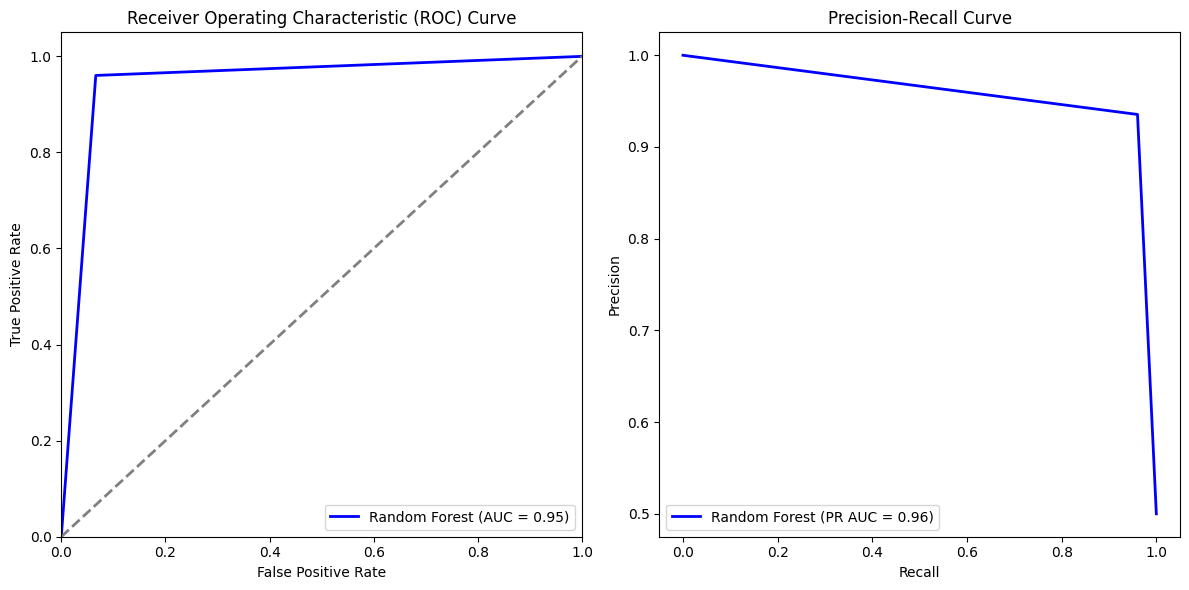

In [36]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve

# Example for plotting ROC-AUC curve for Random Forest
fpr, tpr, thresholds = roc_curve(y_val, y_pred_rf)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(12, 6))

# Plot ROC-AUC Curve
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='blue', lw=2, label=f'Random Forest (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

# Example for PR-AUC curve for Random Forest
precision, recall, _ = precision_recall_curve(y_val, y_pred_rf)
pr_auc = auc(recall, precision)

# Plot PR-AUC Curve
plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label=f'Random Forest (PR AUC = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')

plt.tight_layout()
plt.show()

In [39]:
import joblib

# Save the scaler object
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [ ]:
import joblib

# Save the best performing model (currently, the untuned Random Forest)
joblib.dump(rf, 'final_model.pkl')
print("Saved 'rf' (untuned Random Forest) as final_model.pkl")

Saved 'rf' (untuned Random Forest) as final_model.pkl


In [37]:
tuned_rf_roc_auc = roc_auc_score(y_val, y_pred_best_rf)
tuned_rf_pr_auc = average_precision_score(y_val, y_pred_best_rf)
tuned_gb_roc_auc = roc_auc_score(y_val, y_pred_best_gb)
tuned_gb_pr_auc = average_precision_score(y_val, y_pred_best_gb)

# Create new rows for the tuned models
new_models_data = {
    'Model': ['Tuned Random Forest', 'Tuned Gradient Boosting'],
    'ROC-AUC': [tuned_rf_roc_auc, tuned_gb_roc_auc],
    'PR-AUC': [tuned_rf_pr_auc, tuned_gb_pr_auc]
}
new_models_df = pd.DataFrame(new_models_data)

# Concatenate with the existing comparison_df
comparison_df = pd.concat([comparison_df, new_models_df], ignore_index=True)

print(comparison_df)

                     Model   ROC-AUC    PR-AUC
0      Logistic Regression  0.870540  0.827500
1            Decision Tree  0.909276  0.868798
2            Random Forest  0.946993  0.918140
3        Gradient Boosting  0.907747  0.864089
4      Tuned Random Forest  0.947503  0.919033
5  Tuned Gradient Boosting  0.945973  0.915977


**Reasoning**:
Based on the updated comparison table, I will identify the model with the highest ROC-AUC and PR-AUC scores. The 'Tuned Random Forest' model shows the highest ROC-AUC (0.947503) and PR-AUC (0.919033), making it the best performing model. I will then save this model as 'final_model.pkl'.



In [38]:
import joblib

# Identify the best performing model from the comparison_df
# Based on the output, 'Tuned Random Forest' (best_rf) has the highest ROC-AUC and PR-AUC.

# Save the best performing model
joblib.dump(best_rf, 'final_model.pkl')

print("Saved the best performing model (Tuned Random Forest) as final_model.pkl")

Saved the best performing model (Tuned Random Forest) as final_model.pkl


In [40]:
import pandas as pd

# Convert X_test_scaled (numpy array) back to a DataFrame for saving as CSV
# Re-using columns from the original X_test for clarity

X_test_processed_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)

# Save the processed test data to a CSV file
X_test_processed_df.to_csv('test_processed.csv', index=False)

print("Saved X_test_scaled as 'test_processed.csv'.")

Saved X_test_scaled as 'test_processed.csv'.
